In [1]:
import re
import csv
import os
import math
import time
import json
import itertools
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib
import random as rand
import statsmodels.api as sm
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import product
from hurst import compute_Hc
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox

%matplotlib inline

In [2]:
plt.rcParams["axes.labelsize"] = 16. 
plt.rcParams["xtick.labelsize"] = 14. 
plt.rcParams["ytick.labelsize"] = 14. 
plt.rcParams["legend.fontsize"] = 12. 
plt.rcParams["figure.figsize"] = [12., 7.]

-------

In [3]:
data_real = pd.read_csv('data/sp500_minute-data.csv').ClosePrice

In [4]:
project_path = os.path.dirname(os.getcwd())
json_path = os.path.join(project_path, r"exchange_realization", r"json_files")

In [5]:
json_ddpg_arr = []
for i in range(14):
    json_data = pd.read_json(os.path.join(json_path, r"data_ddpg_"+str(i)+".json"), lines=True)
    json_ddpg_arr.append(json_data.iloc[0].values[0][20:])

json_default_arr = []
for i in range(12):
    json_data = pd.read_json(os.path.join(json_path, r"data_"+str(i)+".json"), lines=True)
    json_default_arr.append(json_data.iloc[0].values[0][20:])

In [6]:
np.min([pd.DataFrame(json_ddpg_arr[k]).pct_change(5).kurt() for k in range(12)])

27.647812225605804

In [7]:
real_data_kurt = np.array([data_real[:15000].pct_change(k).kurt() for k in range(3000)])/100

In [ ]:
aggregation_results = [data_real[k:15000+k].pct_change(5).kurt()/100 for k in range(100000)]

In [ ]:
max(aggregation_results)

In [10]:
# make kurtosis values by lags
ddpg_kurt_arr = []
for i in tqdm(range(14)):
    ddpg_kurt_arr.append([pd.DataFrame(json_ddpg_arr[i]).pct_change(k).kurt() for k in range(3000)])

default_kurt_arr = []
for i in tqdm(range(12)):
    default_kurt_arr.append([pd.DataFrame(json_default_arr[i]).pct_change(k).kurt() for k in range(3000)])

100%|██████████| 12/12 [12:03<00:00, 60.31s/it]


In [11]:
real_data_kurt[5:]

array([23.13369104, 19.27285704, 16.51677779, ...,  0.11644317,
        0.11637622,  0.11631018])

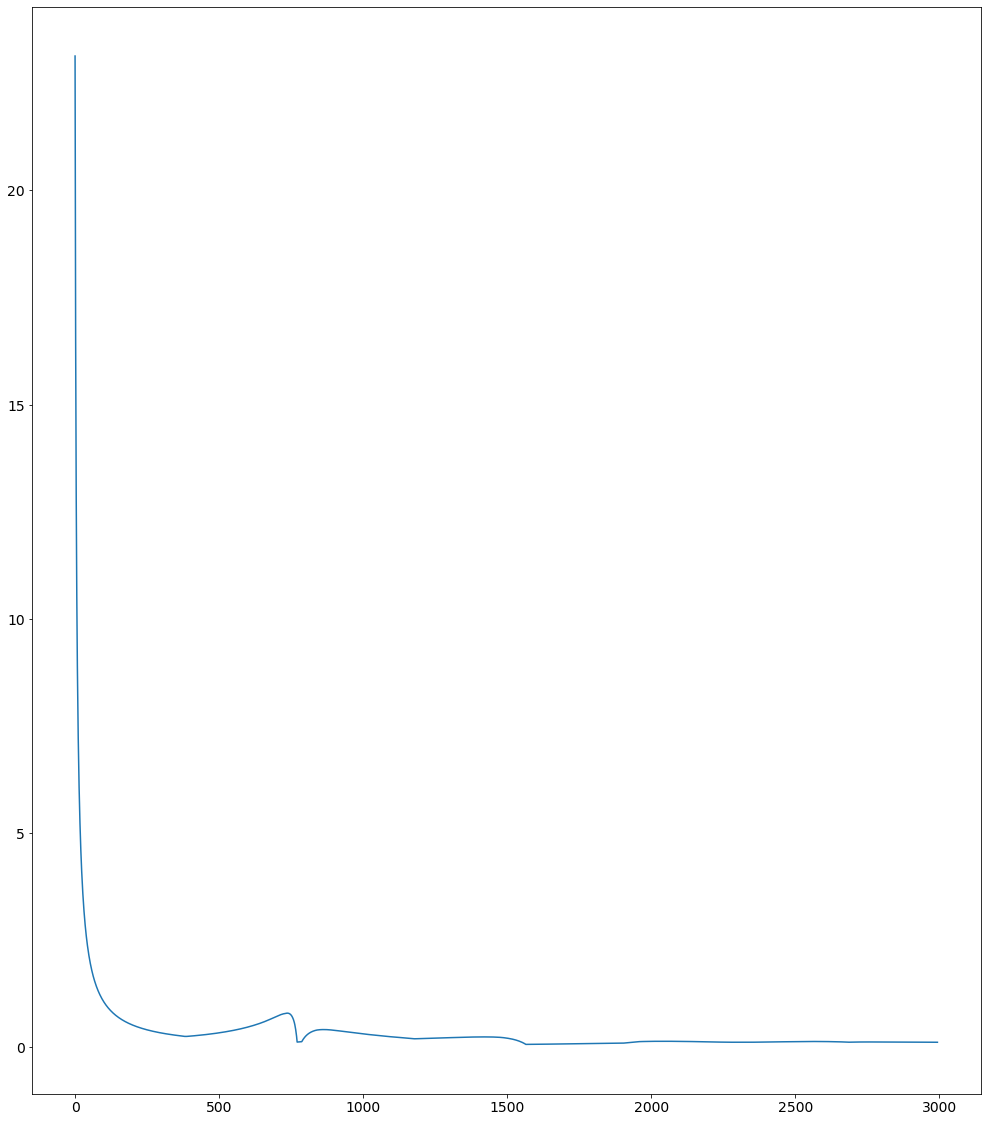

In [12]:
plt.plot(real_data_kurt[5:])
plt.show()

--------


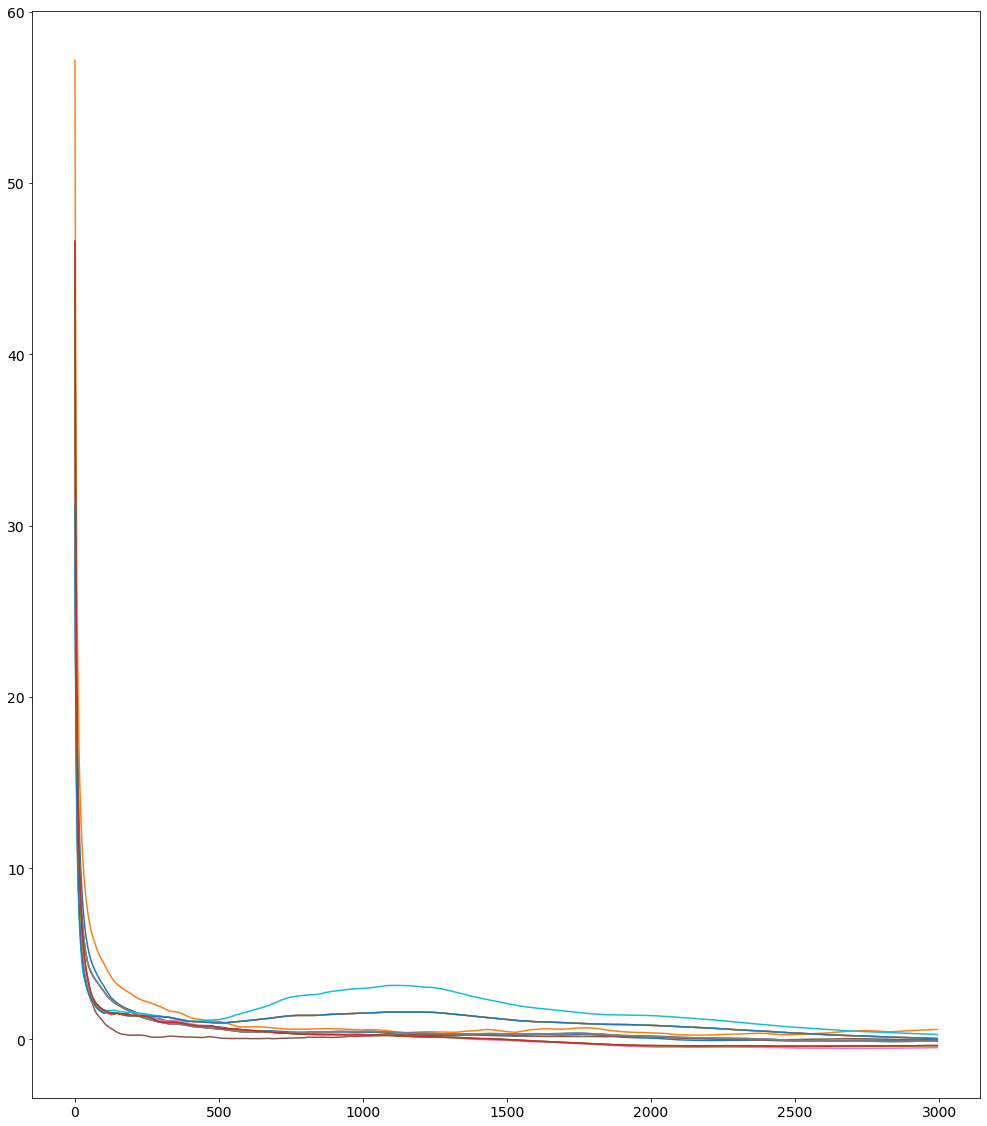

In [13]:
for k in range(len(ddpg_kurt_arr)):
    plt.plot(ddpg_kurt_arr[k][5:])
plt.show()

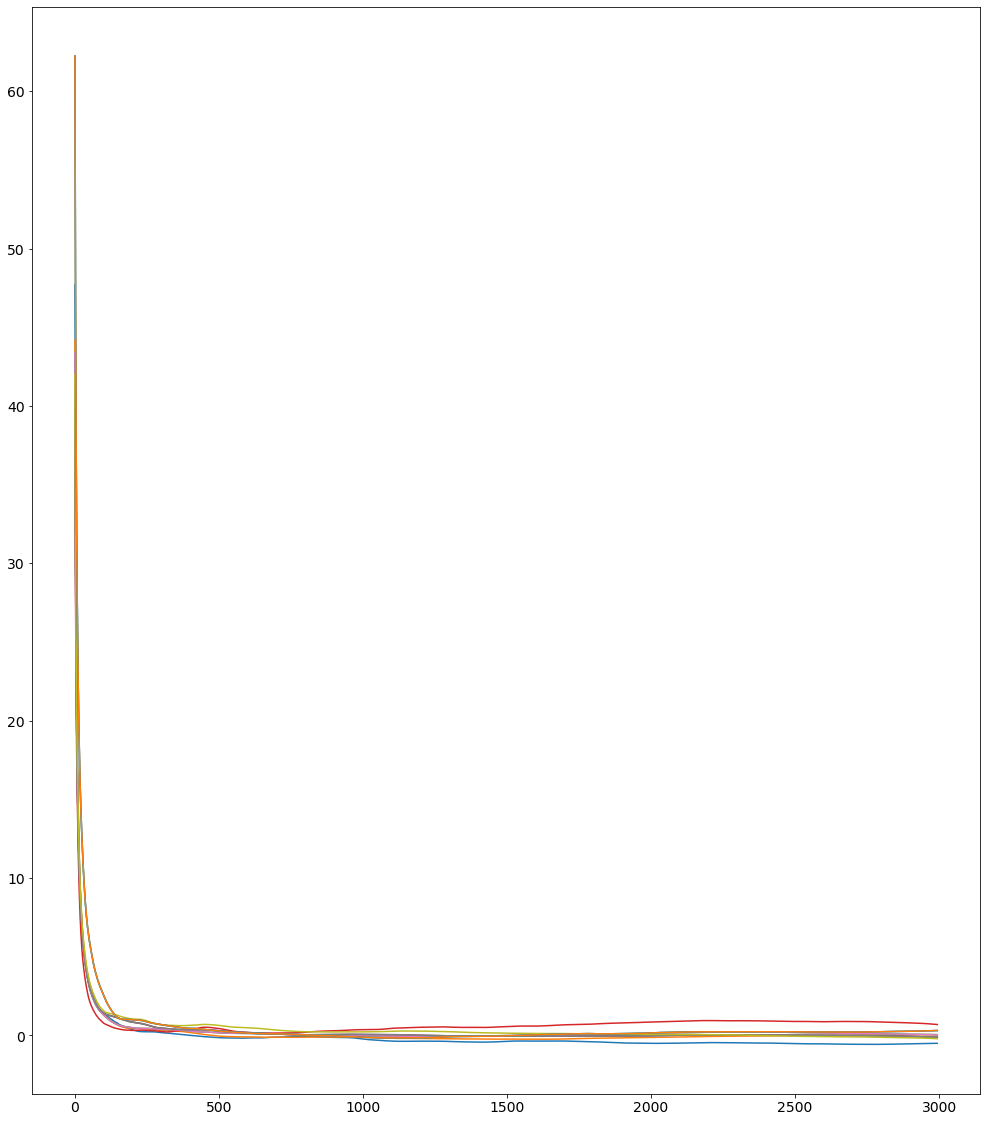

In [14]:
for k in range(len(default_kurt_arr)):
    plt.plot(default_kurt_arr[k][5:])
plt.show()

In [15]:
ddpg_1 = np.array(ddpg_kurt_arr).reshape(14, -1)
default_1 = np.array(default_kurt_arr).reshape(12, -1)

In [16]:
ddpg_median_arr = [np.median(ddpg_1[:, k]) for k in range(3000)]

In [17]:
default_median_arr = [np.median(default_1[:, k]) for k in range(3000)]

In [18]:
ddpg_median_arr[5:][0]

38.757323920956544

In [19]:
ddpg_mean_arr = [np.mean(ddpg_1[:, k]) for k in range(3000)]
default_mean_arr = [np.mean(default_1[:, k]) for k in range(3000)]

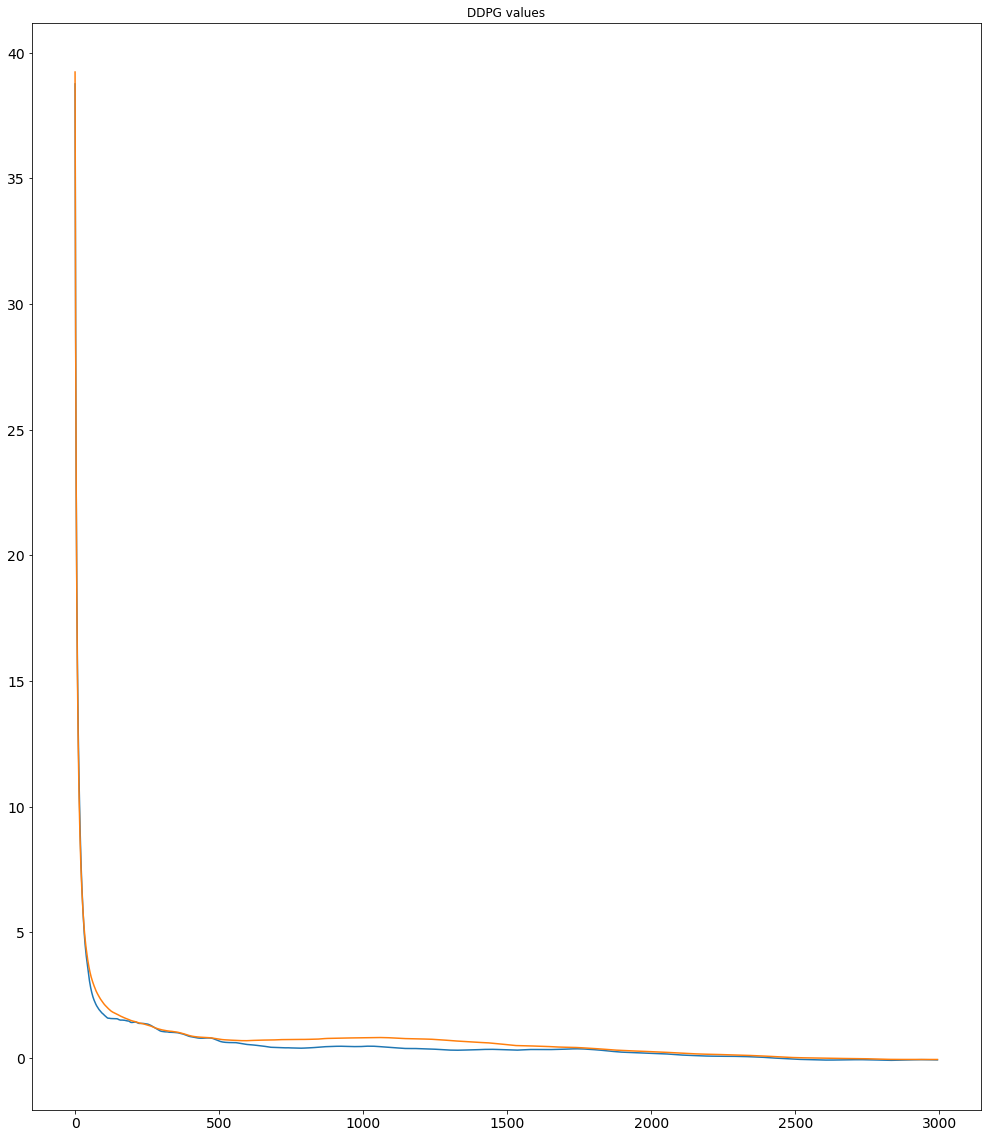

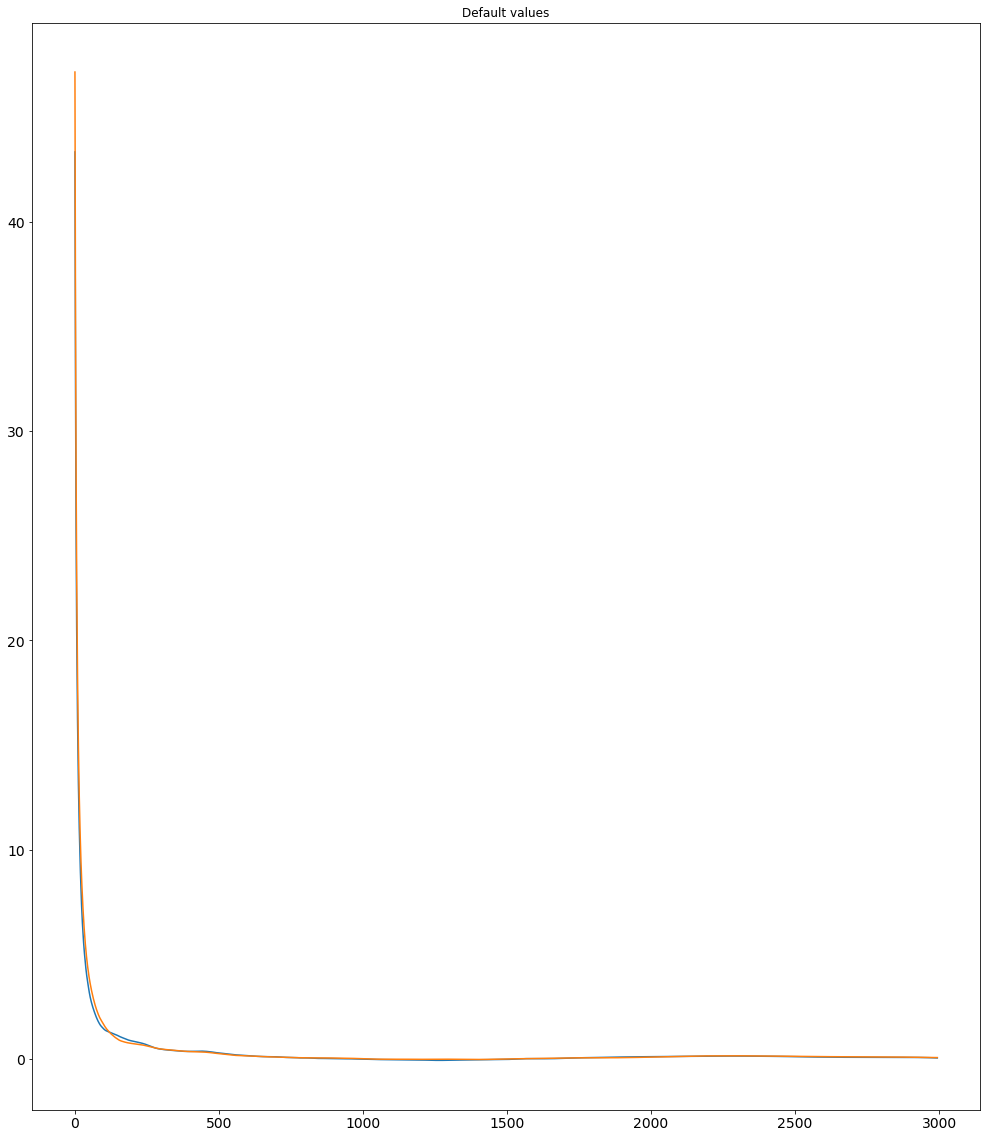

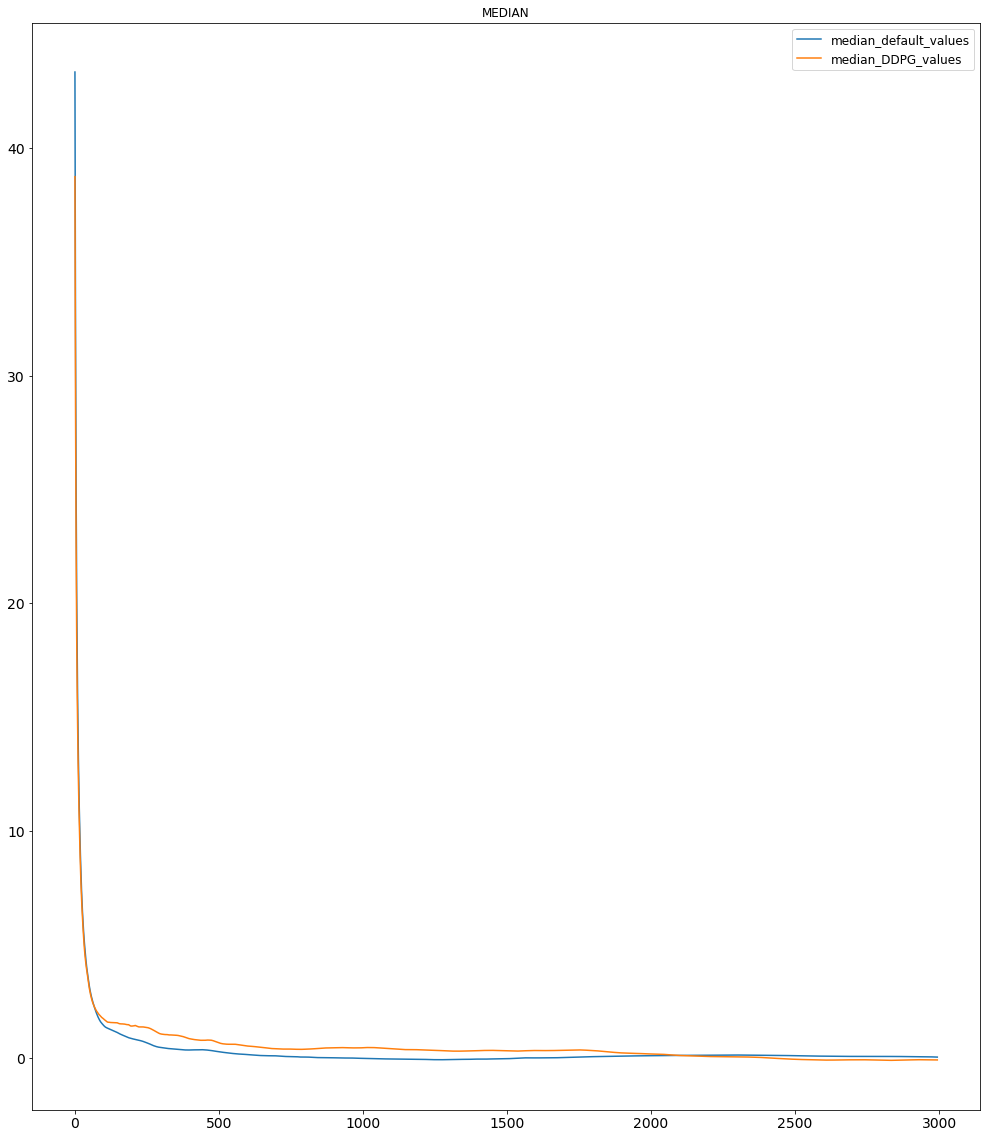

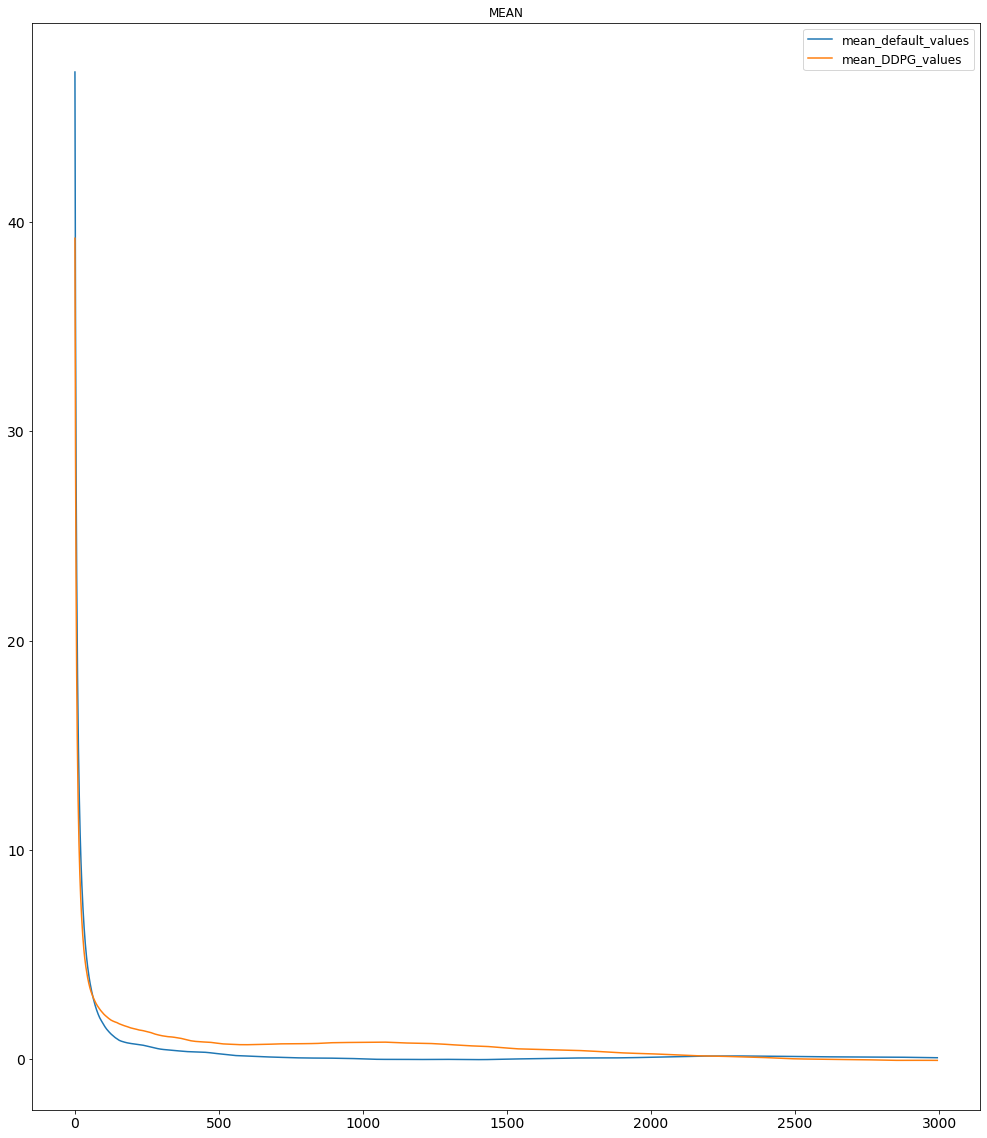

In [20]:
plt.plot(ddpg_median_arr[5:])
plt.plot(ddpg_mean_arr[5:])
plt.title('DDPG values')
plt.show()
plt.plot(default_median_arr[5:])
plt.plot(default_mean_arr[5:])
plt.title('Default values')
plt.show()
plt.plot(default_median_arr[5:], label = 'median_default_values')
plt.plot(ddpg_median_arr[5:], label = 'median_DDPG_values')
plt.legend()
plt.title('MEDIAN')
plt.show()
plt.plot(default_mean_arr[5:], label = 'mean_default_values')
plt.plot(ddpg_mean_arr[5:], label = 'mean_DDPG_values')
plt.legend()
plt.title('MEAN')
plt.show()

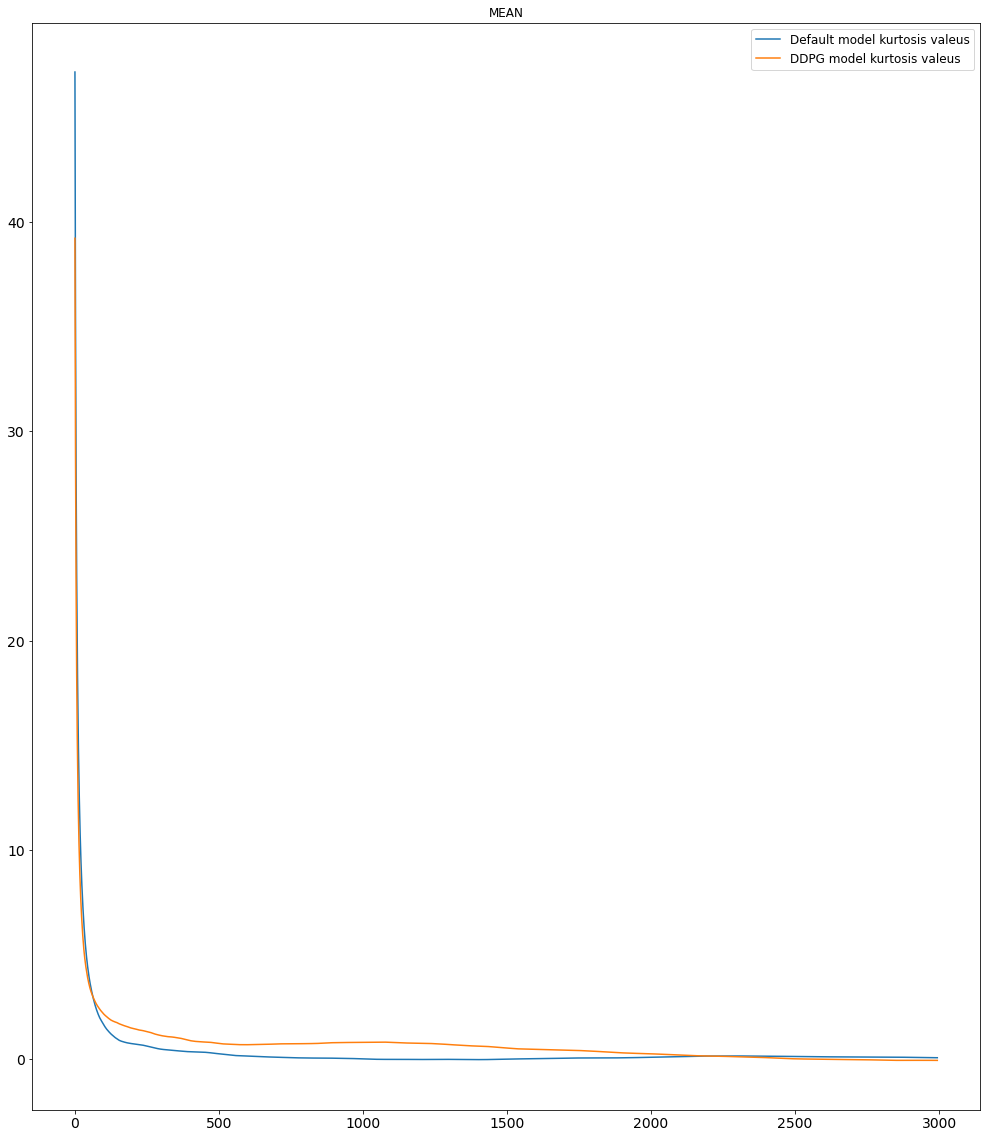

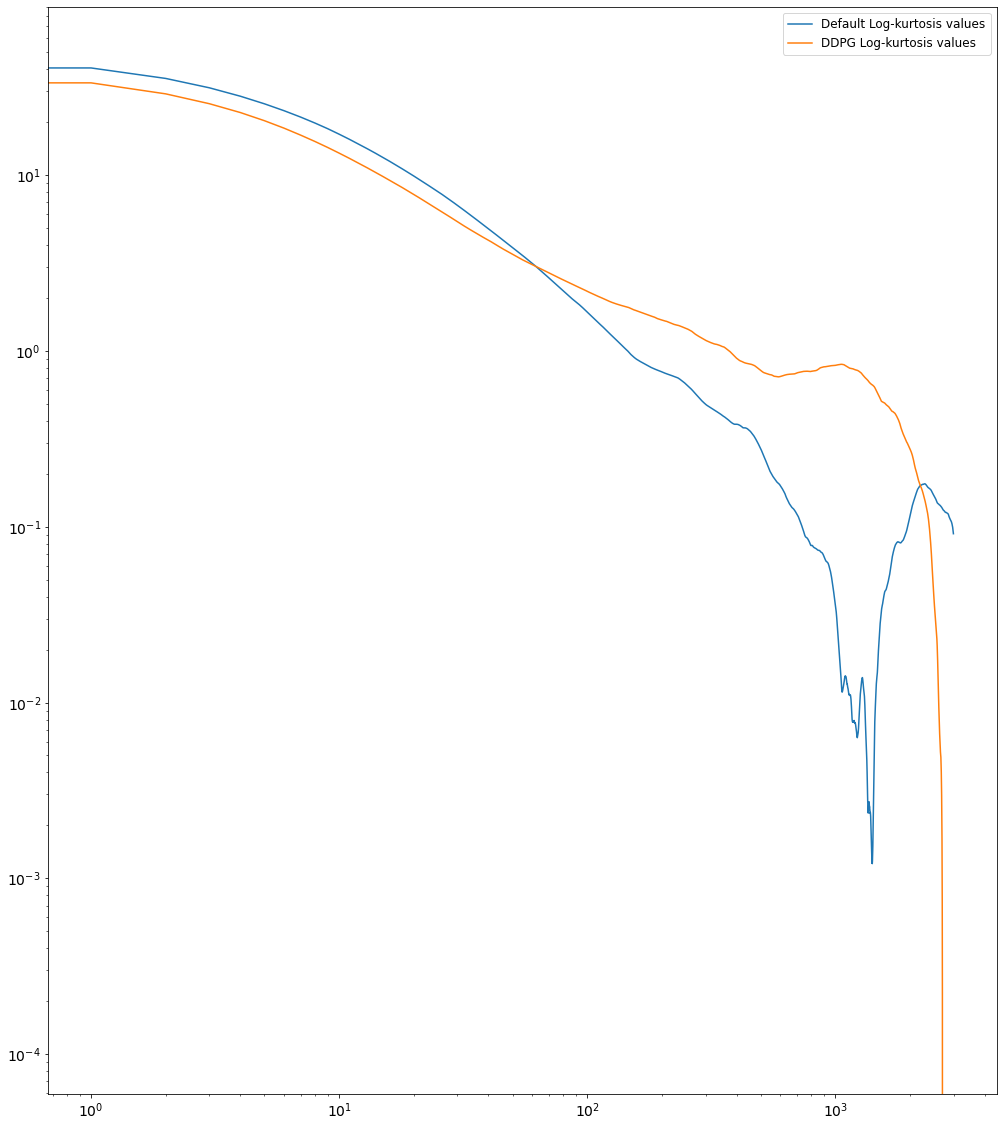

In [21]:
plt.plot(default_mean_arr[5:], label = 'Default model kurtosis valeus')
plt.plot(ddpg_mean_arr[5:], label = 'DDPG model kurtosis valeus')
plt.legend()
plt.title('MEAN')
plt.show()

plt.plot(np.array(default_mean_arr[5:])+0.03, label = 'Default Log-kurtosis values')
plt.plot(np.array(ddpg_mean_arr[5:])+0.03, label = 'DDPG Log-kurtosis values')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

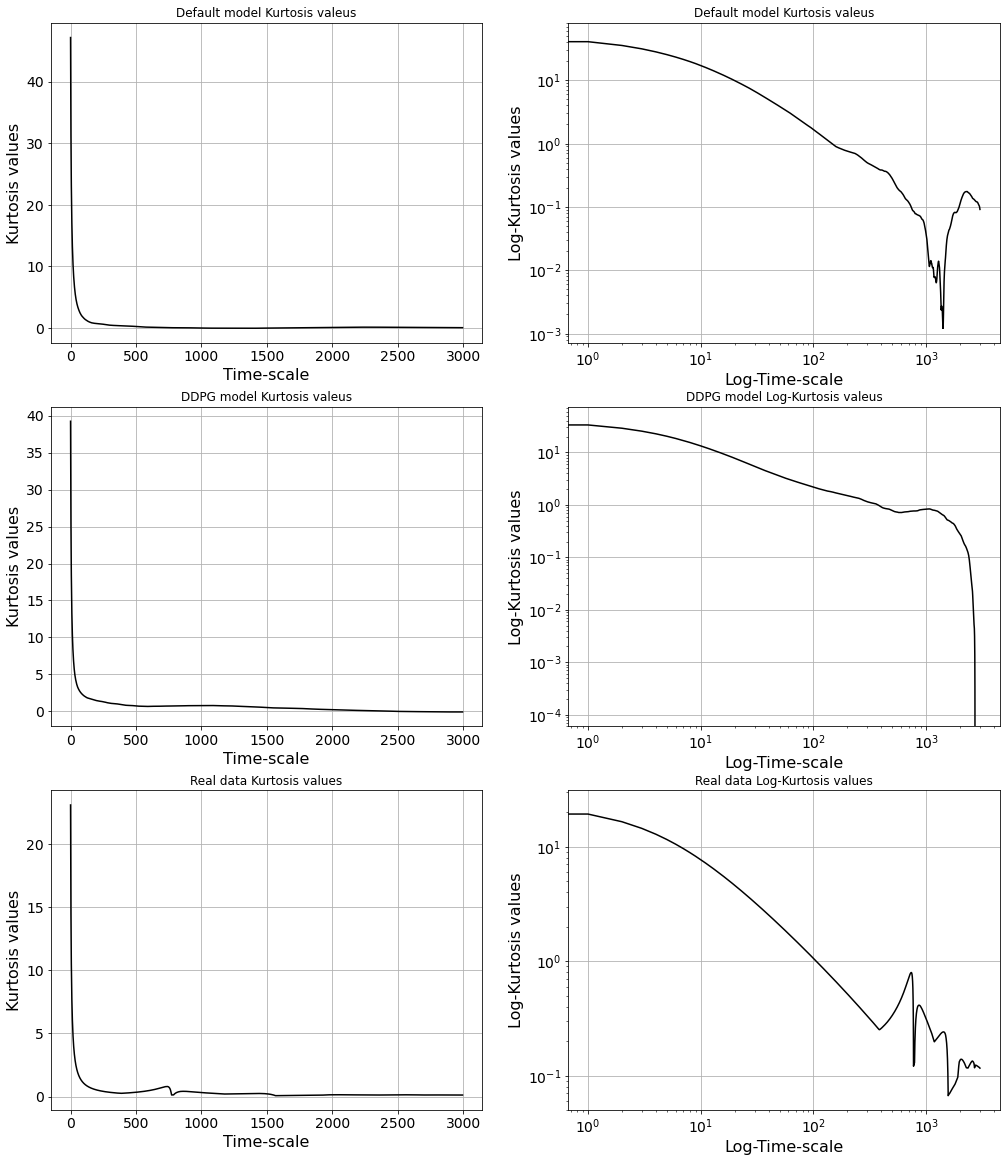

In [233]:
fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(default_mean_arr[5:], color = 'black')
axs[0, 0].set_title('Default model Kurtosis valeus')
axs[0, 0].set_xlabel('Time-scale')
axs[0, 0].set_ylabel('Kurtosis values')
axs[0, 0].grid()

axs[1, 0].plot(ddpg_mean_arr[5:], color = 'black')
axs[1, 0].set_title('DDPG model Kurtosis valeus')
axs[1, 0].set_xlabel('Time-scale')
axs[1, 0].set_ylabel('Kurtosis values')
axs[1, 0].grid()

axs[2, 0].plot(real_data_kurt[5:], color = 'black')
axs[2, 0].set_title('Real data Kurtosis values')
axs[2, 0].set_xlabel('Time-scale')
axs[2, 0].set_ylabel('Kurtosis values')
axs[2, 0].grid()

axs[0, 1].plot(np.array(default_mean_arr[5:])+0.03, color = 'black')
axs[0, 1].set_title('Default model Kurtosis valeus')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('Log-Time-scale')
axs[0, 1].set_ylabel('Log-Kurtosis values')
axs[0, 1].grid()

axs[1, 1].plot(np.array(ddpg_mean_arr[5:])+0.03, color = 'black')
axs[1, 1].set_title('DDPG model Log-Kurtosis valeus')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Log-Time-scale')
axs[1, 1].set_ylabel('Log-Kurtosis values')
axs[1, 1].grid()

axs[2, 1].plot(np.array(real_data_kurt[5:]), color = 'black')
axs[2, 1].set_title('Real data Log-Kurtosis values')
axs[2, 1].set_xscale('log')
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel('Log-Time-scale')
axs[2, 1].set_ylabel('Log-Kurtosis values')
axs[2, 1].grid()

plt.show()

fig.savefig('kurtosis_comparing')

---------
### Returns autocorrelation

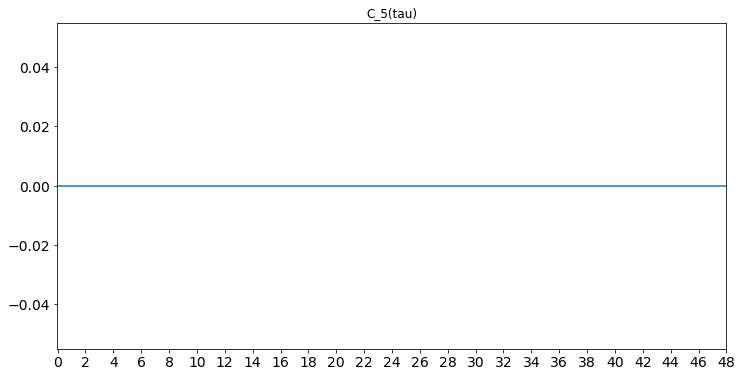

In [23]:
pct_1 = pd.DataFrame(json_ddpg_arr[0]).pct_change()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(pct_1, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_5(tau)')
plt.show()

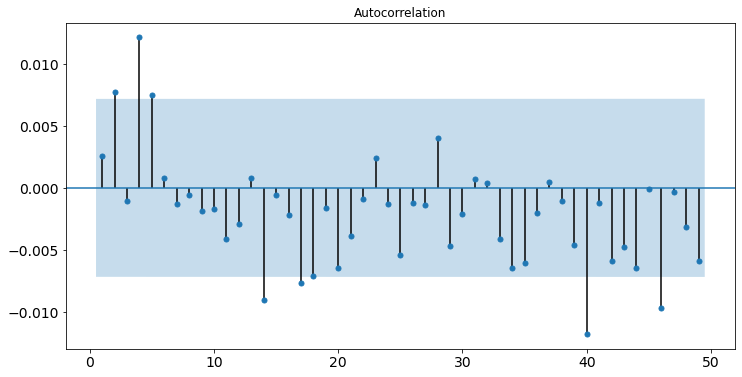

In [24]:
#plot_acf(pct_1.fillna(0).values.reshape(-1), zero = False)
#plt.show()
plot_acf(np.diff(np.array(json_default_arr[3])), zero = False)
plt.show()

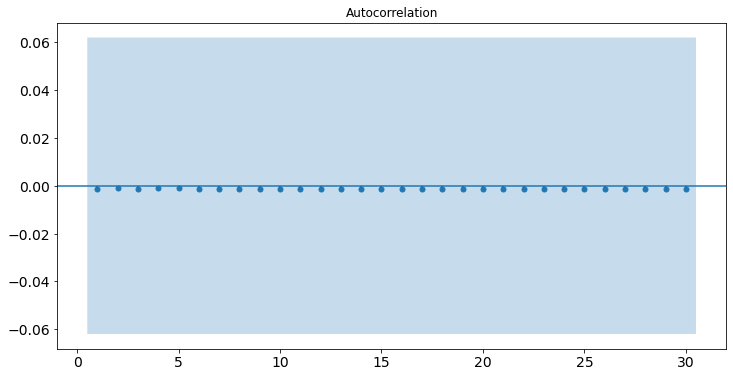

In [25]:
plot_acf(data_real.pct_change().fillna(0).iloc[:1000]**2, zero = False)
plt.show()

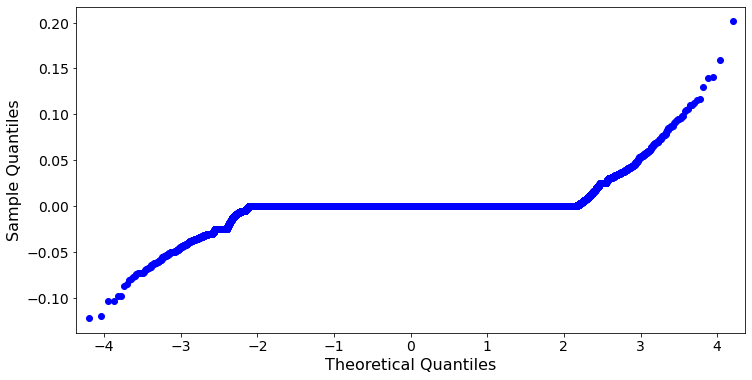

In [26]:
sm.qqplot(np.diff(json_ddpg_arr[6]))
plt.show()

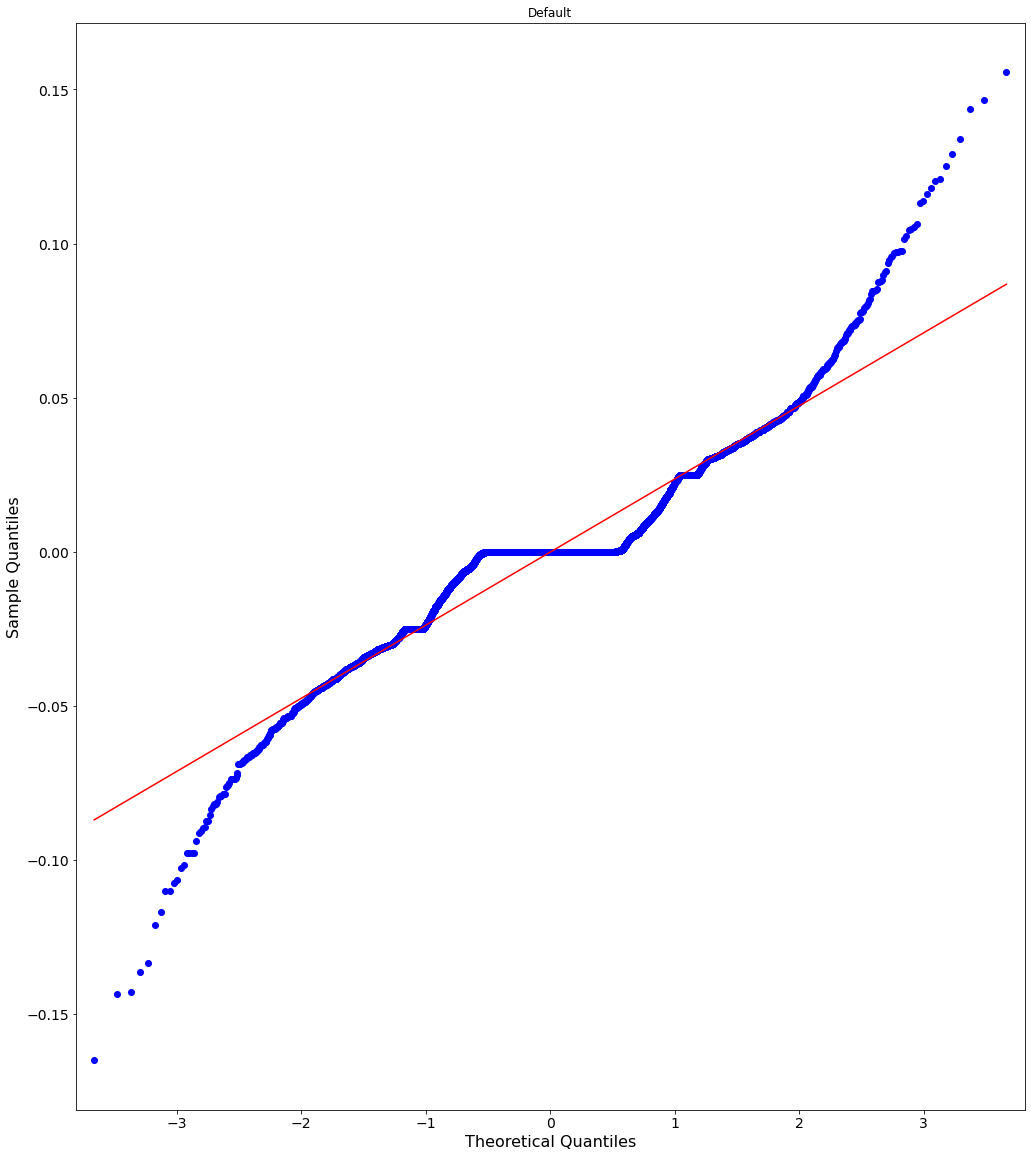

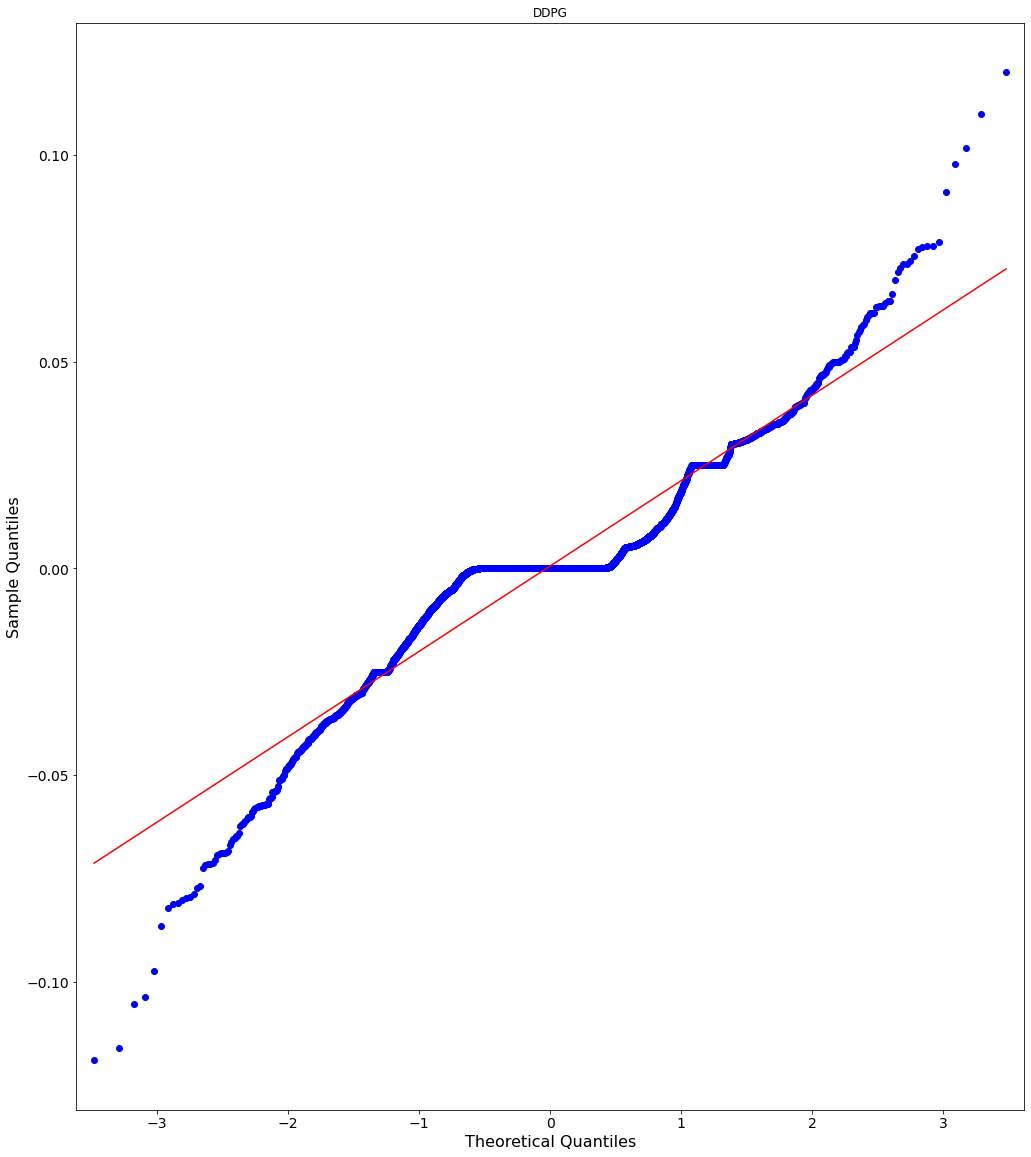

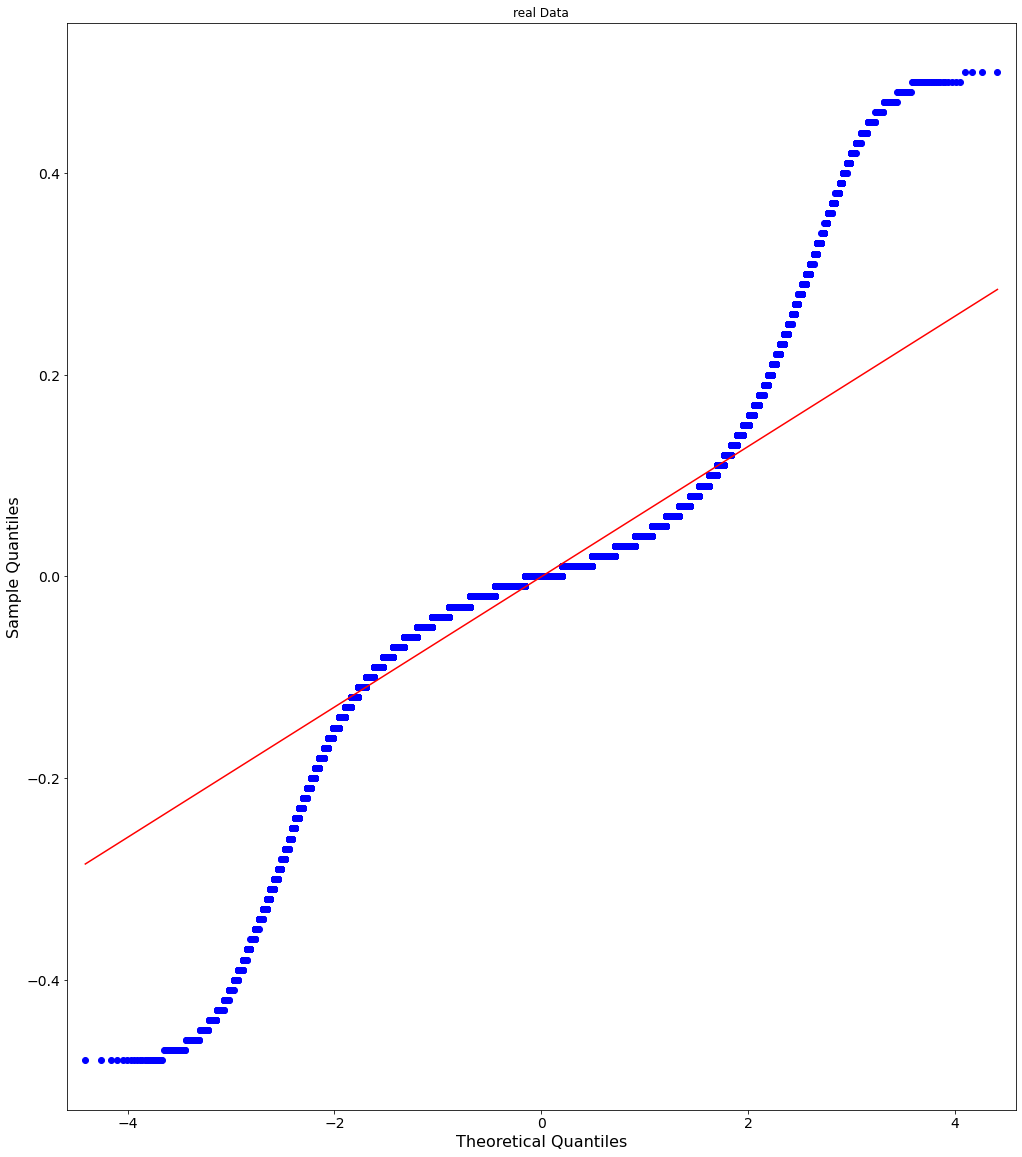

In [207]:
np_arr_1 = np.diff(json_default_arr[6])
sm.qqplot(np.delete(np_arr_1, np.where(np_arr_1==0)[0][:217000]), line = 's')
plt.title('Default')
plt.show()

np_arr_2 = np.diff(json_ddpg_arr[9])
sm.qqplot(np.sort(np.delete(np_arr_2, np.where(np_arr_2==0)[0][:71000]))[3:-3], line = 's')
plt.title('DDPG')
plt.show()

sm.qqplot(np.sort(np.diff(data_real))[1000:-1000], line = 'r')
plt.title('real Data')
plt.show()

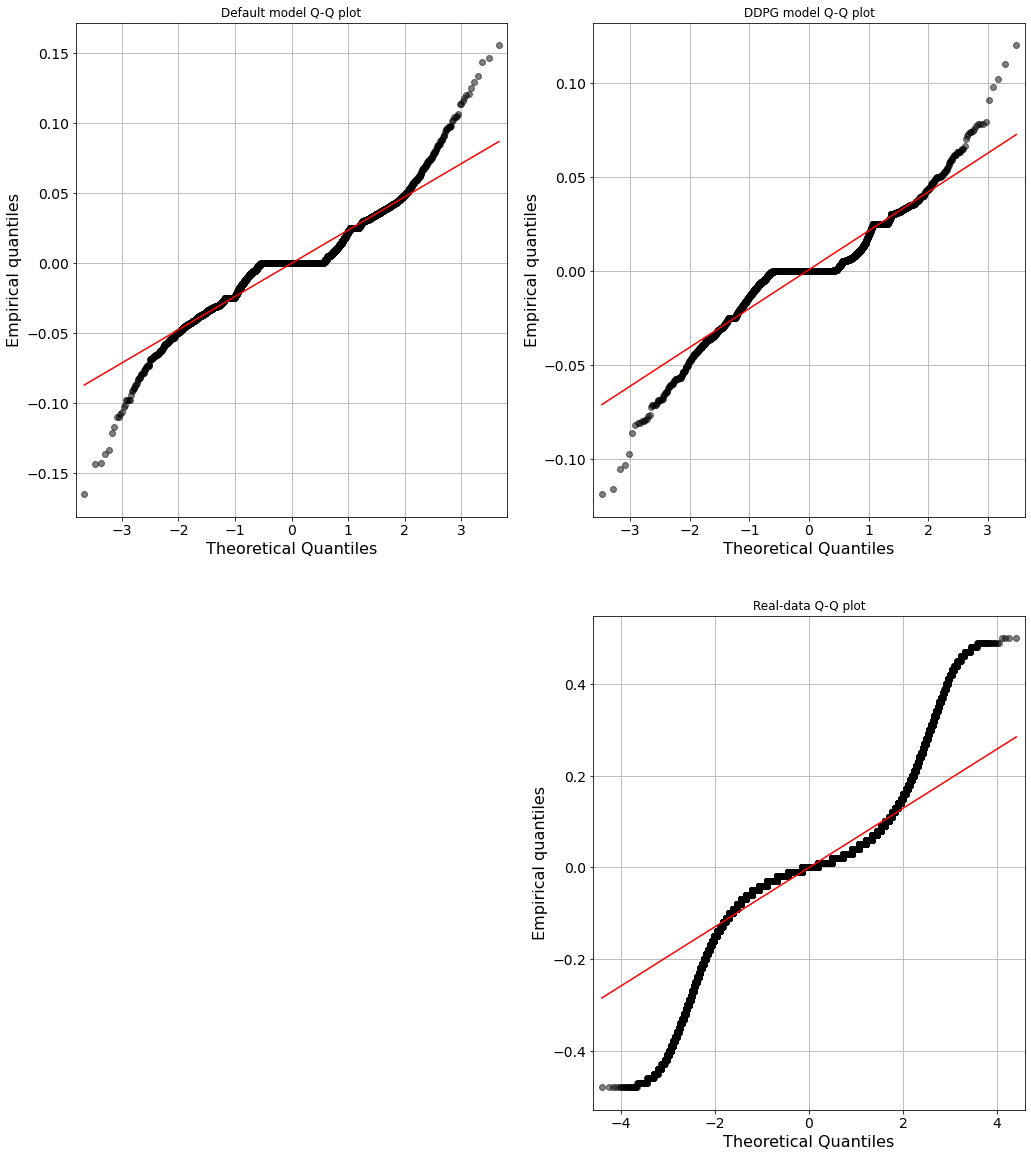

In [275]:
left = -1.8
top = ax.get_ylim()[1] * 0.75

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.qqplot(np.delete(np_arr_1, np.where(np_arr_1==0)[0][:217000]), 
          line = 's', ax = ax, color = 'black', marker = 'o', alpha = 0.5)
ax.set_ylabel('Empirical quantiles')
ax.grid()
plt.title('Default model Q-Q plot')
#txt = ax.text(left, top, 'no keywords', verticalalignment='top')
#txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 2)
sm.qqplot(np.sort(np.delete(np_arr_2, np.where(np_arr_2==0)[0][:71000]))[3:-3], 
          ax = ax, color = 'black', line = 's', marker='o', alpha = 0.5)
ax.set_ylabel('Empirical quantiles')
ax.grid()
plt.title('DDPG model Q-Q plot')

ax = fig.add_subplot(2, 2, 4)
sm.qqplot(np.sort(np.diff(data_real))[1000:-1000], line = 'r', ax = ax, 
          color = 'black', marker='o', alpha = 0.5)
ax.set_ylabel('Empirical quantiles')
ax.grid()
plt.title('Real-data Q-Q plot')

plt.show()

fig.savefig('qq_plot_comparing')

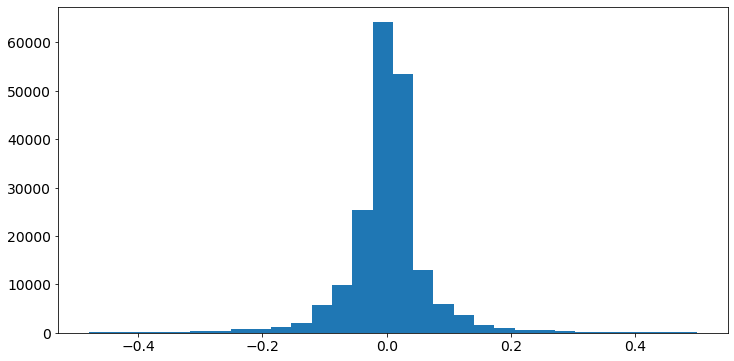

In [29]:
plt.hist(np.sort(np.diff(data_real))[1000:-1000], bins = 30)
plt.show()

In [30]:
gauss_kern = lambda u: 1/np.sqrt(2*np.pi)*np.exp(-u**2/2)
epanch_kern = lambda u: 0.75*max(1-u**2, 0)

def kernel_decomposition(x, X, kern = gauss_kern, h = 0.1):
    return np.mean([1/h*kern((x-k)/h) for k in X])

In [31]:
data_real_norm = np.abs(np.sort(np.diff(data_real)))[1000:-1000]

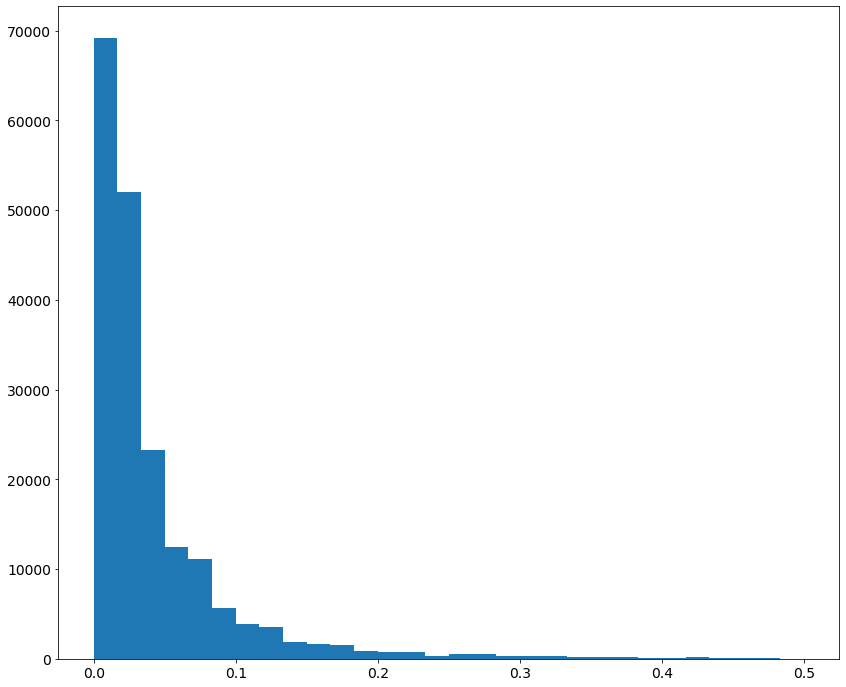

In [436]:
plt.hist(np.abs(np.sort(np.diff(data_real)))[1000:-1000], bins = 30)
plt.show()

In [69]:
data_real_norm = np.sort(np.diff(data_real))[1000:-1000]
data_ddpg_norm = np.sort(np.diff(json_ddpg_arr[9]))
data_default_norm = np.sort(np.diff(json_default_arr[6]))

In [70]:
gauss_ass_real = [kernel_decomposition(x, data_real_norm, kern = gauss_kern, h = 0.1) for x in np.arange(-1, 1, 0.001)]
gauss_ass_ddpg = [kernel_decomposition(x, data_ddpg_norm, kern = gauss_kern, h = 0.1) for x in np.arange(-1, 1, 0.001)]
gauss_ass_default = [kernel_decomposition(x, data_default_norm, kern = gauss_kern, h = 0.1) for x in np.arange(-1, 1, 0.001)]

In [192]:
data_real_norm_2 = np.sort(np.diff(data_real))[45000:-45000]
data_real_norm_1 = np.sort(np.diff(data_real))#[1000:-1000]
#gauss_ass_real_1 = [kernel_decomposition(x, data_real_norm_1, kern = gauss_kern, h = 0.1) for x in np.arange(-1, 1, 0.001)]
gauss_ass_real_2 = [kernel_decomposition(x, data_real_norm_2, kern = gauss_kern, h = 0.1) for x in np.arange(-1, 1, 0.001)]

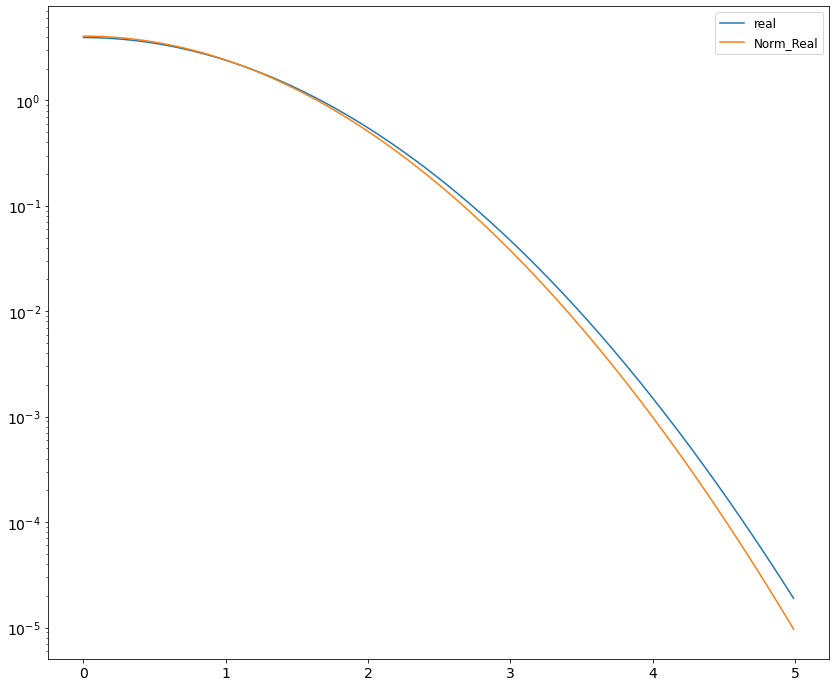

In [580]:
#plt.plot(np.arange(0, 10, 0.01)[:400], gauss_ass_ddpg[1000:][:400], label = 'DDPG')
plt.plot(np.arange(0, 10, 0.01)[:500], np.array(gauss_ass_real_2)[1000:][:500], label = 'real')
#plt.plot(np.arange(0, 10, 0.01)[:480], np.array(gauss_ass_default)[1000:][:480], label = 'default')
plt.plot(np.arange(0, 10, 0.01)[:500], ss.norm.pdf(np.arange(0, 10, 0.01)[:500], loc = np.mean(gauss_ass_real_2)-0.5, scale = np.std(gauss_ass_real))*10, label = 'Norm_Real')
#plt.plot(np.arange(0, 10, 0.01)[:400], ss.norm.pdf(np.arange(0, 0.06, 0.00006)[:400], loc = np.mean(data_default_norm), scale = np.std(data_default_norm))/22., label = 'Norm_Default')
#plt.plot(np.arange(0, 10, 0.01)[:400], ss.norm.pdf(np.arange(0, 0.06, 0.00006)[:400], loc = np.mean(data_ddpg_norm), scale = np.std(data_ddpg_norm))/20.5, label = 'Norm_DDPG')
#plt.scatter([0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999], quantile_arr)
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

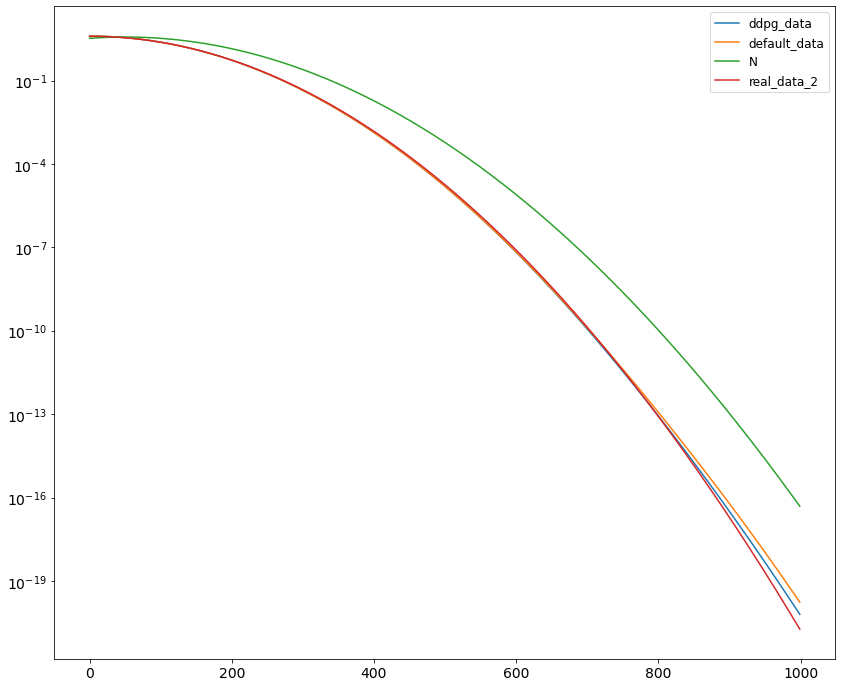

In [452]:
#plt.plot(gauss_ass_real[1000:], label = 'real_data')
plt.plot(gauss_ass_ddpg[1000:], label = 'ddpg_data')
plt.plot(gauss_ass_default[1000:], label = 'default_data')
plt.plot(ss.norm.pdf(np.arange(0, 10, 0.01), 
                     loc = np.mean(gauss_ass_ddpg), 
                     scale = np.std(gauss_ass_ddpg))*10, label = 'N')
plt.plot(gauss_ass_real_2[1000:], label = 'real_data_2')
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

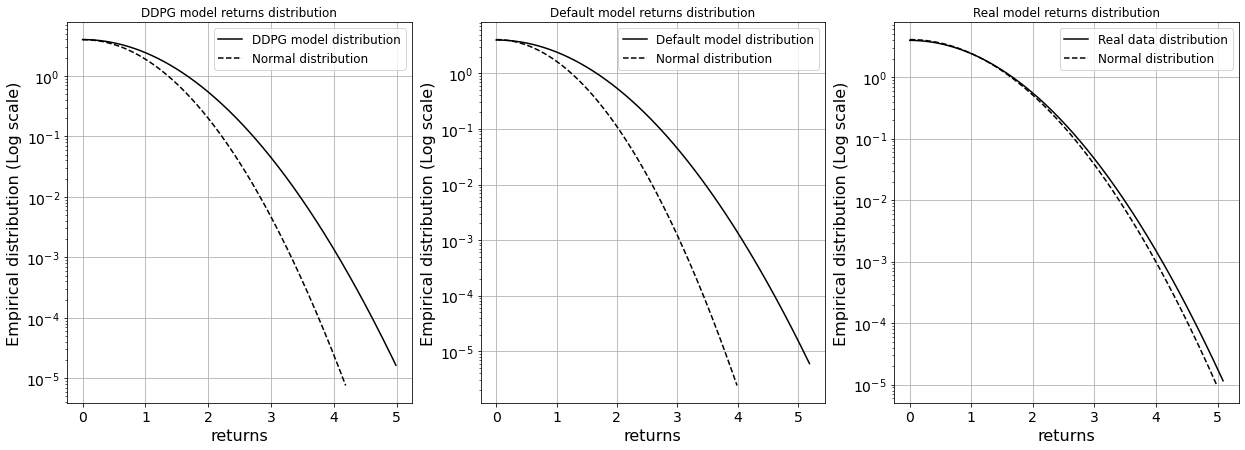

In [590]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs[0].plot(np.arange(0, 10, 0.01)[:500], gauss_ass_ddpg[1000:][:500], label = 'DDPG model distribution', color = 'black')
axs[0].plot(np.arange(0, 10, 0.01)[:420], ss.norm.pdf(np.arange(0, 0.06, 0.00006)[:420], 
                                                      loc = np.mean(data_ddpg_norm), 
                                                      scale = np.std(data_ddpg_norm))/20.5, 
            label = 'Normal distribution', color = 'black', linestyle = 'dashed')
axs[0].set_title('DDPG model returns distribution')
axs[0].set_xlabel('returns')
axs[0].set_ylabel('Empirical distribution (Log scale)')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.arange(0, 10, 0.01)[:520], np.array(gauss_ass_default)[1000:][:520], label = 'Default model distribution', color = 'black')
axs[1].plot(np.arange(0, 10, 0.01)[:400], ss.norm.pdf(np.arange(0, 0.06, 0.00006)[:400], 
                                                      loc = np.mean(data_default_norm), 
                                                      scale = np.std(data_default_norm))/22., 
            label = 'Normal distribution', color = 'black', linestyle='dashed')
axs[1].set_title('Default model returns distribution')
axs[1].set_xlabel('returns')
axs[1].set_ylabel('Empirical distribution (Log scale)')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(np.arange(0, 10, 0.01)[:510], np.array(gauss_ass_real_2)[1000:][:510], label = 'Real data distribution', color = 'black')
axs[2].plot(np.arange(0, 10, 0.01)[:500], ss.norm.pdf(np.arange(0, 10, 0.01)[:500], 
                                                      loc = np.mean(gauss_ass_real_2)-0.5, 
                                                      scale = np.std(gauss_ass_real))*10, 
            label = 'Normal distribution', color = 'black', linestyle = 'dashed')
axs[2].set_title('Real model returns distribution')
axs[2].set_xlabel('returns')
axs[2].set_ylabel('Empirical distribution (Log scale)')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].grid(True)

plt.show()
fig.savefig('empirical_dist_comparing')

---------
### Hill estimates

In [649]:
ddpg_log_ret = np.diff(np.log(json_ddpg_arr[9]))
default_log_ret = np.diff(np.log(json_default_arr[6]))

abs_ddpg_log_ret = np.sort(np.abs((ddpg_log_ret-np.mean(ddpg_log_ret))/np.std(ddpg_log_ret)))
abs_default_log_ret = np.abs((default_log_ret-np.mean(default_log_ret))/np.std(default_log_ret))

In [654]:
0.1/(np.sum(np.log(abs_ddpg_log_ret[-pers_ddpg_1:])) - np.log(abs_ddpg_log_ret[-pers_ddpg_1]))
0.1/(np.sum(abs_ddpg_log_ret[-pers_ddpg_1:]) - abs_ddpg_log_ret[-pers_ddpg_1])

9.741620383912135e-06

In [60]:
### !!!!!!!!!!!!
### Be careful!
def Hill_estimator(data):
    ordered = np.sort(data)
    n = ordered.shape[0]

    Hill_est = []
    log_row = np.log(ordered)

    for k in tqdm(range(0, n-1)):
        summ = 1/(k+1)*np.sum([(log_row[-1-i]-log_row[-2-k]) for i in range(k+1)])
        
        Hill_est.append(summ)
    print('done!')
    kappa = 1. / np.array(Hill_est)
    return kappa

In [166]:
Hill_estimator_ddpg = Hill_estimator(np.sort(np.diff(json_ddpg_arr[9])))

<ipython-input-60-555952c144f6>:8: RuntimeWarning: divide by zero encountered in log
  log_row = np.log(ordered)
<ipython-input-60-555952c144f6>:8: RuntimeWarning: invalid value encountered in log
  log_row = np.log(ordered)
  2%|▏         | 1451/74994 [00:00<00:32, 2279.82it/s]<ipython-input-60-555952c144f6>:11: RuntimeWarning: invalid value encountered in double_scalars
  summ = 1/(k+1)*np.sum([(log_row[-1-i]-log_row[-2-k]) for i in range(k+1)])
100%|██████████| 74994/74994 [55:29<00:00, 22.53it/s]    

done!


In [71]:
Hill_estimator_default = Hill_estimator(np.diff(json_default_arr[6][:100000]))
#Hill_estimator_real = Hill_estimator(np.sort(np.diff(data_real[:110000]))[1000:-1000])

<ipython-input-60-555952c144f6>:8: RuntimeWarning: divide by zero encountered in log
  log_row = np.log(ordered)
<ipython-input-60-555952c144f6>:8: RuntimeWarning: invalid value encountered in log
  log_row = np.log(ordered)
  1%|          | 1059/99998 [00:00<00:30, 3242.59it/s]<ipython-input-60-555952c144f6>:11: RuntimeWarning: invalid value encountered in double_scalars
  summ = 1/(k+1)*np.sum([(log_row[-1-i]-log_row[-2-k]) for i in range(k+1)])
  1%|          | 953/107998 [00:00<00:22, 4764.19it/s]

done!


100%|██████████| 107998/107998 [46:08<00:00, 39.01it/s]

done!


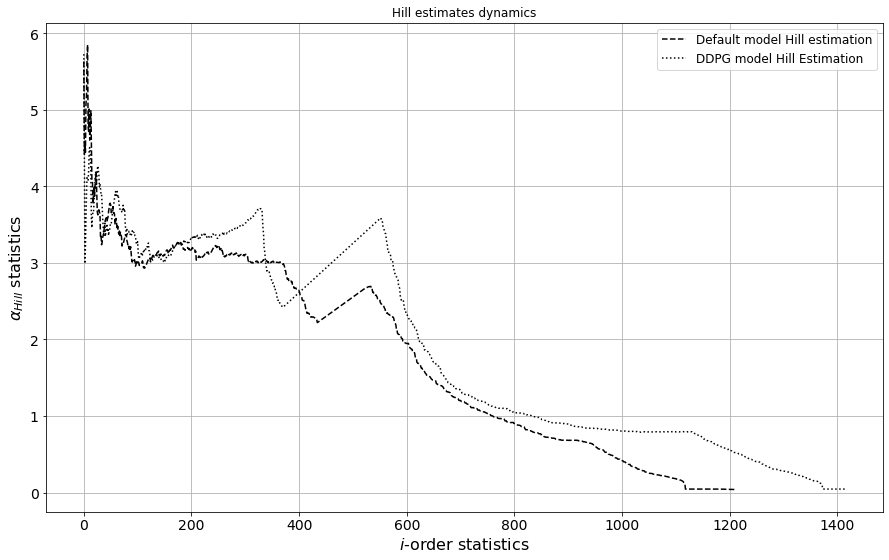

In [167]:
fig, axs = plt.subplots(1, 1)
axs.plot(Hill_estimator_default[3:1214], label = 'Default model Hill estimation', color = 'black', linestyle = 'dashed')
axs.plot(Hill_estimator_ddpg[5:1420], label = 'DDPG model Hill Estimation', color = 'black', linestyle = ':')
axs.legend()
axs.set_xlabel('$i$-order statistics')
axs.set_ylabel(r'$\alpha_{Hill}$ statistics')
axs.set_title('Hill estimates dynamics')
axs.grid(True)
plt.show()
fig.savefig('Hill_estimates')

In [155]:
#plt.plot(Hill_estimator_real[600:])
#plt.show()

In [226]:
Hill_estimator_default[30]

3.669018224862167

In [225]:
Hill_estimator_ddpg[31]

4.268538940366847

In [224]:
Hill_estimator_real[250]

15.773293827949551

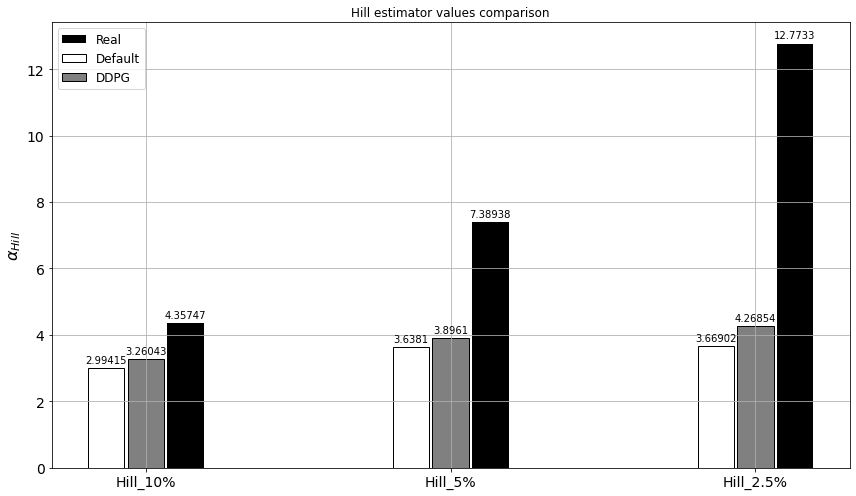

In [73]:
labels = ['Hill_10%', 'Hill_5%', 'Hill_2.5%']

real_estimator = [4.35746511, 7.389382963, 12.7732938]
default_estimator = [2.994153480474, 3.6380975749, 3.669018224486]
ddpg_estimator = [3.260433108664754, 3.8961022247, 4.268538940366847]

x = np.arange(len(labels))  # the label locations
width = 0.12  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x + width+0.01, real_estimator, width, label='Real', color = 'black')
rects2 = ax.bar(x - width-0.01, default_estimator, width, label='Default', color = 'white', edgecolor = 'black')
rects3 = ax.bar(x, ddpg_estimator, width, label='DDPG', color = 'gray', edgecolor = 'black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\alpha_{Hill}$')
ax.set_title('Hill estimator values comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding = 3)

fig.tight_layout()

ax.grid(True)
plt.show()
fig.savefig('Hill_bar')